# Loose EEGNet
This notebook is a neural network that is based as much off of the EEGNet paper as I could understand.



---



# Import/Install all necessary packages and libraries

In [ ]:
!pip install mne

In [ ]:
import numpy as np

from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable, gradcheck
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd

from matplotlib import pyplot

import mne
from mne.io import concatenate_raws, read_raw_fif
import mne.viz

import math

from os import walk

# Check for GPU availability and set device

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Load and format the data

In [ ]:
data_file = '/content/drive/My Drive/data/P_01.fif'

epochs = mne.read_epochs(data_file, verbose='error')
print(epochs.info)

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 64
 projs: []
 sfreq: 256.0 Hz
>


In [ ]:
epochs_UN = epochs['FU', 'FN'] # Unpleasant vs. Neutral
epochs_UP = epochs['FU', 'FP'] # Unpleasant vs. Pleasant
epochs_NP = epochs['FN', 'FP'] # Neutral vs. Pleasant

# Dataset with unpleasant and neutral events
print(epochs_UN)
data_UN = epochs_UN.get_data() #we will classify between unpleasant and neutral
labels_UN = epochs_UN.events[:,-1]
print(len(labels_UN))

<EpochsFIF  |   249 events (all good), 0 - 1.49609 sec, baseline off, ~46.9 MB, data loaded,
 'FN': 126
 'FU': 123>
249


In [ ]:
torch.manual_seed(3)
torch.cuda.manual_seed(3)
train_data_UN, test_data_UN, labels_train_UN, labels_test_UN = train_test_split(data_UN, labels_UN, test_size=0.3, random_state=42)

In [ ]:
print(labels_train_UN.shape, labels_test_UN.shape, train_data_UN.shape)
chunk_train = labels_UN.shape[0]
chunk_test = labels_test_UN.shape[0]
channels = train_data_UN.shape[1]
timepoints = train_data_UN.shape[2]


(174,) (75,) (174, 64, 384)


In [ ]:
BATCH_SIZE = 8
BATCH_SIZE2 = chunk_test

eeg_data_scaler = StandardScaler()

X_train = eeg_data_scaler.fit_transform(data_UN.reshape(-1, data_UN.shape[-1])).reshape(data_UN.shape)

labels_UN = np.array([1 if x > 0 else 0 for x in labels_UN])

labels_UN = labels_UN.reshape((chunk_train, 1))
labels_UN = labels_UN.astype(np.float32)
X_actual = torch.from_numpy(labels_UN)

X_train = torch.from_numpy(X_train)
X_train = X_train.unsqueeze(1)

train_batches = math.ceil(chunk_train / BATCH_SIZE)
test_batches = math.ceil(chunk_test / BATCH_SIZE2)
print(X_train.shape, X_actual.shape, train_batches, test_batches)

torch.Size([249, 1, 64, 384]) torch.Size([249, 1]) 32 1


# Build the model and train
A short breakdown of the paper:
> EEGNet is a CNN for classification and interpretation of EEG-based BCI's

> Benefits of EEGNet:
> 1. Can be applied to different BCI paradagims (MI, ERP, SSVEP)
> 2. Can be trained with very limited data
> 3. Can produce neurophysiologically interpretable features

> The model architecture:
> 1. Fit 2D convolutional filters of size (1, sampling rate//2)
> 2. Use a depthwise convolution of size (# of channels, 1)
> 3. Add a separable convolution of size (1, 16)
> 4. Flatten the data and feed it through a classification layer







In [ ]:
# hyperparameters
freq, avg1stride, avg2stride = 256, (1, 4), (1, 8)
convstride = 1 # stride for each conv2D
conv1_neurons = 2
conv2_neurons = 4
conv3_neurons = 8
conv4_neurons = 4
kern1size = freq // 2
kern3size = 32
no_splits = 10

In [ ]:
padding_needed = (kern1size - 1) / 2
conv1outx, conv1outy = (channels, (timepoints + (2 * padding_needed) - kern1size)/convstride + 1)

conv2outx, conv2outy = ((conv1outx - channels)/convstride + 1, conv1outy)
conv2outx, conv2outy = conv2outx // avg1stride[0], conv2outy // avg1stride[1]

conv3outx, conv3outy = (conv2outx, (conv2outy - kern3size)/convstride + 1)

conv4outx, conv4outy = (conv3outx, conv3outy)
conv4outx, conv4outy = (conv4outx // avg2stride[0], conv4outy // avg2stride[1])
flat1_in = int(conv4outx * conv4outy * conv4_neurons)

Model description, layer by layer

1. Temporal convolution
> * - Uses filters of (1, sampling frequency // 2)
> * - Learns frequency filters at 2Hz and above
2. Depthwise convolution
> * - Learns spatial filters
3. Separable Convolution
> * - Conists of a deptwise convolution followed by a pointwise convolution
> * - First learnes a kernel summarizing each feature map, then merges the outputs
4. Fully connected layer
> * - Consists of a linear layer that reduces the channels, followed by a sigmoid classification

In [ ]:
class ConstrainedConv2d(nn.Conv2d):
    def forward(self, input):
        return F.conv2d(input, self.weight.clamp(min=-1.0, max=1.0), self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

In [ ]:
CNNPoor = nn.Sequential(
    nn.ZeroPad2d((math.floor(padding_needed), math.ceil(padding_needed), 0, 0)),
    nn.Conv2d(1, conv1_neurons, (1, kern1size), bias=False),
    nn.ELU(),
    nn.BatchNorm2d(conv1_neurons),
    
    ConstrainedConv2d(conv1_neurons, conv2_neurons, (channels, 1), bias=False, groups = conv1_neurons),
    nn.ELU(),
    nn.BatchNorm2d(conv2_neurons),
    nn.AvgPool2d(avg1stride),
    nn.Dropout(),
    
    nn.Conv2d(conv2_neurons, conv3_neurons, (1, kern3size), bias=False, groups = conv2_neurons),
    nn.Conv2d(conv3_neurons, conv4_neurons, kernel_size=1, bias=False),
    nn.ELU(),
    nn.BatchNorm2d(conv4_neurons),
    nn.AvgPool2d(avg2stride),
    nn.Dropout(),
    
    nn.Flatten(),

    nn.Linear(flat1_in, 1),
    nn.Sigmoid(),
)

CNNPoor.to(device)

In [ ]:
loss_function = nn.BCELoss()
optimizer = optim.Adam(CNNPoor.parameters(), lr = 0.001)
kfold = KFold(n_splits=no_splits)

In [ ]:
def test(model, device, test_loader):
    
    model.eval()
    correct = 0
    tot_loss = 0
    acc_score, prec_score, rec_score = 0, 0, 0
    with torch.no_grad():
        for (data, labels) in test_loader:
            data, labels = data.to(device), labels.to(device)
            
            classification = model(data.float())
            loss = loss_function(classification, labels)

            pred = torch.round(classification)
            correct += pred.eq(labels.view_as(pred)).sum().item()
            tot_loss += loss.item()

            acc_score += accuracy_score(labels, pred)
            prec_score += precision_score(labels, pred)
            rec_score += recall_score(labels, pred)

        print("\nTest set: Average loss: {:.6f}, Accuracy: {:.6f}".format(tot_loss / test_batches, 
                                                                          correct / len(test_loader.dataset)))
        print("sklearn accuracy: {:.6f} precision: {:.6f} recall: {:.6f}\n".format(acc_score / test_batches,
                                                                                   prec_score / test_batches,
                                                                                   rec_score / test_batches))
        return (tot_loss / test_batches, acc_score / test_batches, prec_score / test_batches, rec_score / test_batches)

In [ ]:
def train(model, device, train_loader, optimizer, epoch):

    model.train()
    correct = 0
    tot_loss = 0
    for batch, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        classification = model(data.float())
        loss = loss_function(classification, labels)

        loss.backward()
        optimizer.step()

        pred = torch.round(classification)
        correct += pred.eq(labels.view_as(pred)).sum().item()
        tot_loss += loss.item()
    print("Epoch: {}".format(epoch))
    print("\tAverage loss: {:.6f}".format(tot_loss / batch))
    print("\tAccuracy: {:.6f}".format(correct / len(train_loader.dataset)))
    return (tot_loss / batch, correct / len(train_loader.dataset))

In [ ]:
plots = {"train loss": [],
         "train acc": [],
         "test loss": [],
         "test acc": [],
         "test prec": [],
         "test rec": []}
for train_index, test_index in kfold.split(X_train, X_actual):
    x_train_fold = X_train[train_index]
    x_test_fold = X_train[test_index]
    y_train_fold = X_actual[train_index]
    y_test_fold = X_actual[test_index]

    trainset = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
    testset = torch.utils.data.TensorDataset(x_test_fold, y_test_fold)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = False)
    test_loader = torch.utils.data.DataLoader(testset, batch_size = BATCH_SIZE2, shuffle = False)

    for epoch in range(5):
        trl, tra = train(CNNPoor, device, train_loader, optimizer, epoch)
        plots["train loss"].append(trl)
        plots["train acc"].append(tra)
        tl, ta, tp, tr = test(CNNPoor, device, test_loader)
        plots["test loss"].append(tl)
        plots["test acc"].append(ta)
        plots["test prec"].append(tp)
        plots["test rec"].append(tr)

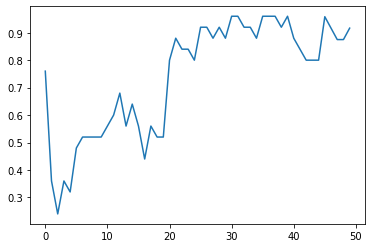

In [ ]:
pyplot.plot(plots["test acc"])